In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import pandas as pd

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Version:  2.3.1
Eager mode:  True
Hub version:  0.9.0
GPU is NOT AVAILABLE


In [2]:
dataset = pd.read_csv('Codalab-train-dataset.csv')
X = dataset.iloc[:, 1].values
Y = dataset.iloc[:,2].values


In [3]:
label_encoder_Y = LabelEncoder()
Y = label_encoder_Y.fit_transform(Y)
len(X)

8000

In [4]:
train_examples, test_examples, train_labels, test_labels = train_test_split(X,Y, test_size=0.2,random_state=0)
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))
print("TRAIN Dataset -> ")
print(train_examples[:10])
print(" Test Dataset ->")
print(train_labels[:10])

Training entries: 6400, test entries: 1600
TRAIN Dataset -> 
['Better to have loved and lost, than to have never loved at all.'
 "I left my Adderall in my Ford Fiesta. Now it's a @FordFocus"
 "My wife and I just made a porno. Too bad she's my late wife."
 'Life consists not in holding good cards, but in playing those you hold well.'
 '"Your tongue is germ free only if it is pink. If it is white there is a thin film of bacteria on it"'
 "My wife was excited when I blindfolded her in the bedroom... until I spun her around 10 times and let her know we're playing pin the tail on the donkey."
 'Do deaf girls masturbate with one hand so they can moan with the other?'
 "People who support the Endangered Species Act haven't tasted my Bald Eagle Souffle"
 'What do you get when you mix a rhinoceros with an elephant? Elephino...'
 "Why don't feminists work cash registers? They can't make change."]
 Test Dataset ->
[0 1 1 0 0 1 1 1 1 1]


# <font color="green">Build the model </font> <br>
The neural network is created by stacking layers—this requires three main architectural decisions:
 * How to represent the text?
 * How many layers to use in the model?
 * How many *hidden units* to use for each layer? 
In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
 *   we don't have to worry about text preprocessing,
 *   we can benefit from transfer learning.
 
For this example we will use a model from [TensorFlow Hub] (https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).
There are three other models to test for the sake of this tutorial:
 * [google/tf2-preview/gnews-swivel-20dim-with-oov/1] (https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) - same as [google/tf2-preview/gnews-swivel-20dim/1] (https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1), but with 2.5% vocabulary converted to OOV buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.
 * [google/tf2-preview/nnlm-en-dim50/1] (https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) - A much larger model with ~1M vocabulary size and 50 dimensions.
 * [google/tf2-preview/nnlm-en-dim128/1] (https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) - Even larger model with ~1M vocabulary size and 128 dimensions.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.


In [5]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 0.44719145, -1.5973505 ,  0.2546199 , -0.8516619 , -1.73577   ,
        -1.5770794 , -0.90960264,  0.50025064,  0.5210855 ,  1.5478182 ,
        -0.6385991 ,  0.34887943, -0.34293476,  0.66420096, -2.2303002 ,
         0.19195345,  1.8363161 , -1.4339712 , -0.3239795 , -0.42090243],
       [-0.0108667 , -1.486056  ,  0.64470637, -0.4451046 , -1.1206563 ,
        -0.13002694, -1.734623  ,  0.63932997,  1.1968429 ,  0.05877944,
        -2.3390641 ,  0.802865  ,  0.84517807, -0.26993877, -0.9686946 ,
         0.14467284,  0.5665953 , -0.72215796, -0.29738063, -0.3138543 ],
       [ 0.16252269, -2.1696181 ,  0.41122207, -1.0587252 , -1.3136382 ,
         0.2262041 , -2.0814402 ,  1.9685557 ,  3.32715   ,  0.5687373 ,
        -2.5922117 ,  0.07035743,  0.8817193 , -0.22154713, -1.7557862 ,
         0.03955548,  1.0019549 , -1.172705  , -0.90711534, -0.7019589 ]],
      dtype=float32)>

<font color="green">Let's now build the full model: </font>

In [6]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


<font color="green"> The layers are stacked sequentially to build the classifier: </font> <br>
 
 1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
 2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
 3. The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

<font color="green"> Hidden units </font> <br>
 
The above model has two intermediate or "hidden" layers, between the input and output. 
The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.
 
If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

<font color="green">Loss function and optimizer </font> <br>
 
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 
 
This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.
 
Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.
 
<font color="green">Now, configure the model to use an optimizer and a loss function: </font>

In [7]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])


<font color="green">Create a validation set </font>

When training, we want to check the accuracy of the model on data it hasn't seen before. <br>
Create a *validation set* by setting apart 10,000 examples from the original training data. <br> 
(Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [8]:
len(train_examples)
x_val = train_examples[:2500]
partial_x_train = train_examples[2500:]

y_val = train_labels[:2500]
partial_y_train = train_labels[2500:]
len(partial_x_train)

3900

<font color="green">Train the model </font> <br>
Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [9]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
8/8 [==============================] - 0s 28ms/step - loss: 0.8841 - accuracy: 0.3833 - val_loss: 0.7950 - val_accuracy: 0.4104
Epoch 2/40
8/8 [==============================] - 0s 12ms/step - loss: 0.7461 - accuracy: 0.4856 - val_loss: 0.7091 - val_accuracy: 0.5444
Epoch 3/40
8/8 [==============================] - 0s 11ms/step - loss: 0.6817 - accuracy: 0.5849 - val_loss: 0.6757 - val_accuracy: 0.6096
Epoch 4/40
8/8 [==============================] - 0s 12ms/step - loss: 0.6525 - accuracy: 0.6277 - val_loss: 0.6589 - val_accuracy: 0.6308
Epoch 5/40
8/8 [==============================] - 0s 12ms/step - loss: 0.6322 - accuracy: 0.6413 - val_loss: 0.6426 - val_accuracy: 0.6408
Epoch 6/40
8/8 [==============================] - 0s 12ms/step - loss: 0.6113 - accuracy: 0.6562 - val_loss: 0.6262 - val_accuracy: 0.6480
Epoch 7/40
8/8 [==============================] - 0s 10ms/step - loss: 0.5916 - accuracy: 0.6687 - val_loss: 0.6112 - val_accuracy: 0.6592
Epoch 8/40
8/8 [===========

<font color="green"> Evaluate the model </font> <br>
And let's see how the model performs. Two values will be returned. <br>
-> Loss (a number which represents our error, lower values are better), and <br>
-> accuracy.

In [13]:
y_pred = model.predict_classes(X)
results = model.evaluate(test_examples, test_labels)
print("length of y_pred", len(y_pred))
print(y_pred)
print("*******CODALAB************",results)

50/50 [==============================] - 0s 2ms/step - loss: 0.3549 - accuracy: 0.8438
length of y_pred 8000
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]
*******CODALAB************ [0.3549339175224304, 0.84375]



This fairly naive approach achieves an accuracy of about 85%. With more advanced approaches, the model should get closer to 95%.<br>

Create a graph of accuracy and loss over time<br>
`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [17]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

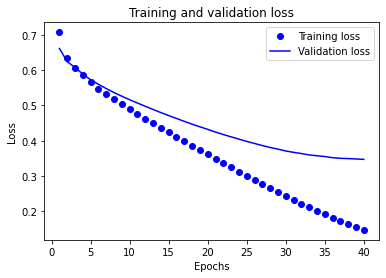

In [18]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

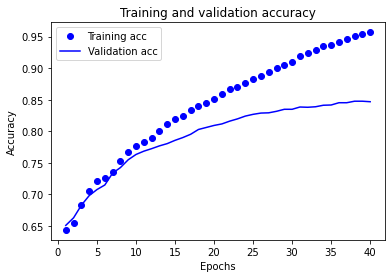

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

In [26]:
codalab_data = pd.read_csv('train.csv')

In [26]:
# MOST FREQUESNT
from sklearn.impute import SimpleImputer 
constant_imputer=SimpleImputer(strategy='most_frequent')
codalab_data.iloc[:,:]=constant_imputer.fit_transform(codalab_data)
#x_array = np.array(codalab_data['funniness_all'])
#normalized_X = preprocessing.normalize([x_array])
print(codalab_data.isnull().sum())

id                  0
text                0
is_humor_all        0
funniness_all       0
funniness_female    0
funniness_male      0
funniness_18_25     0
funniness_26_40     0
funniness_41_55     0
funniness_56_70     0
is_off_all          0
offense_all         0
is_off_female       0
offense_female      0
is_off_male         0
offense_male        0
is_off_18_25        0
offense_18_25       0
is_off_26_40        0
offense_26_40       0
is_off_41_55        0
offense_41_55       0
is_off_56_70        0
offense_56_70       0
dtype: int64


In [27]:
# COnstant, have used this
from sklearn.impute import SimpleImputer 
constant_imputer=SimpleImputer(strategy='constant', fill_value=0)
codalab_data.iloc[:,:]=constant_imputer.fit_transform(codalab_data)
#x_array = np.array(codalab_data['funniness_all'])
#normalized_X = preprocessing.normalize([x_array])
print(codalab_data.isnull().sum())

id                   0
text                 0
is_humor             0
humor_rating         0
humor_controversy    0
offense_rating       0
dtype: int64


In [24]:
# ignored this
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ['humor_rating', 'humor_controversy'] 
new_cols = ['is_humor']
X = codalab_data[cols]
y = codalab_data[new_cols]
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))
X=codalab_data[X.columns[rfe.support_]]
print(X.head())

Selected features: ['humor_rating', 'humor_controversy']
   humor_rating  humor_controversy
0          2.42                1.0
1          2.50                1.0
2          1.95                0.0
3          2.11                1.0
4          2.78                0.0


/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [28]:
cols = ['humor_rating', 'humor_controversy'] 
new_cols = ['is_humor']
X = codalab_data[cols]
y = codalab_data[new_cols]
X_temp,X_test,y_temp,y_test=train_test_split(X,y,test_size=0.2,random_state=1111)
train_examples, test_examples, train_labels, test_labels = train_test_split(X_temp,y_temp, test_size=0.1,random_state=0)
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))
print("TRAIN Dataset -> ")
print(train_examples[:10])
print(" Test Dataset ->")
print(train_labels[:20])

Training entries: 5760, test entries: 640
TRAIN Dataset -> 
      humor_rating  humor_controversy
7762          3.30                0.0
2713          0.00                0.0
4721          2.95                1.0
3785          0.00                0.0
3219          0.00                0.0
3434          2.60                1.0
7503          2.00                0.0
1796          2.95                0.0
2363          1.78                1.0
4516          1.79                1.0
 Test Dataset ->
      is_humor
7762         1
2713         0
4721         1
3785         0
3219         0
3434         1
7503         1
1796         1
2363         1
4516         1
4219         1
990          1
6866         1
561          0
1820         1
923          0
2849         0
6083         1
2964         1
3843         0


In [30]:
#Used most_frequent strategy
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression(random_state=101)
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(scores_accuracy)
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

K-fold cross-validation results:
[0.9975  0.995   0.99875 1.      1.      0.99625 0.99625 1.      0.9975
 0.9975 ]
LogisticRegression average accuracy is 0.998
LogisticRegression average log_loss is 0.009
LogisticRegression average auc is 1.000


/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
#have not run this one
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = codalab_data.iloc[:, 3:23].values
Y = codalab_data.iloc[:,2].values
label_encoder_Y = LabelEncoder()
Y = label_encoder_Y.fit_transform(Y)

kfold = KFold(n_splits=10, random_state=105,shuffle=True)
model = LogisticRegression()
results = cross_val_score(model, X, Y, cv=kfold,scoring='accuracy')
print("Accuracy in each split:",results)
print("Accuracy:", results.mean())
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [33]:
# have not executed this one

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = codalab_data.iloc[:, 3:8].values
Y = codalab_data.iloc[:,2].values
label_encoder_Y = LabelEncoder()
Y = label_encoder_Y.fit_transform(Y)

kf=KFold(n_splits=10)
splits=kf.split(X)

for train_index, test_index in splits:
    print(len(train_index),len(test_index))
    

rfr = RandomForestRegressor(n_estimators=25, random_state=1111)
errors=[]
for train_index, val_index in splits:
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    rfr.fit(X_train, y_train)
    predictions = rfr.predict(X_test)
    print("Split accuracy: " + str(mean_squared_error(y_val, predictions)))
# Access the training and validation indices of splits

    
    #model = LogisticRegression()
    #results = cross_val_score(model, X, Y, cv=kfold)
    #print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
    #print(len(X_val),len(y_val))
    # Fit the random forest model
    #
    # Make predictions, and print the accuracy
    #predictions = rfc.predict(X_val)
    

54 6
54 6
54 6
54 6
54 6
54 6
54 6
54 6
54 6
54 6


In [33]:
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
n_samples = X.shape[0]
clf = svm.SVC(kernel='linear', C=1)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 1.00 (+/- 0.00)


/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/punitmashruwala/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected.